In [ ]:
!pip install pyldavis

In [ ]:
!pip install bertopic flair

# Imports

In [ ]:
import re
import nltk
import string
import pyLDAvis
from pprint import pprint
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from bertopic import BERTopic
import pyLDAvis.gensim_models as gensimvis
from gensim.models.ldamodel import LdaModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore" , category=DeprecationWarning)
pyLDAvis.enable_notebook()
tqdm.pandas()
plt.style.use("ggplot")

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

<a id="read_data"></a>
# 3. Reading data

In [ ]:
data = pd.read_excel("/content/Pubmed5k.xlsx")

In [ ]:
data.head()

,ArticleID,Title,Abstract
0,34153941,Stable Coordination Variability in Overground ...,Coordination variability (CV) is commonly anal...
1,34153942,Weak Hip Strength Increases Dynamic Knee Valgu...,Clinical Scenario: Dynamic knee valgus (DKV) i...
2,34153964,Current and Future Projections of Amyotrophic ...,Various methodologies have been reported to as...
3,34153968,Disparities between Asian and Non-Asian Thromb...,As outcomes for acute ischemic stroke (AIS) va...
4,34153978,Maternal Factors Predicting Loss to Follow-Up ...,Because hearing loss in children can result in...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleID  4999 non-null   int64 
 1   Title      4999 non-null   object
 2   Abstract   4999 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [ ]:
data = data.astype({"ArticleID": int, "Title": str, "Abstract": str})

In [ ]:
data["all_text"] = data["Title"]+data["Abstract"]

In [ ]:
data.head()

,ArticleID,Title,Abstract,all_text
0,34153941,Stable Coordination Variability in Overground ...,Coordination variability (CV) is commonly anal...,Stable Coordination Variability in Overground ...
1,34153942,Weak Hip Strength Increases Dynamic Knee Valgu...,Clinical Scenario: Dynamic knee valgus (DKV) i...,Weak Hip Strength Increases Dynamic Knee Valgu...
2,34153964,Current and Future Projections of Amyotrophic ...,Various methodologies have been reported to as...,Current and Future Projections of Amyotrophic ...
3,34153968,Disparities between Asian and Non-Asian Thromb...,As outcomes for acute ischemic stroke (AIS) va...,Disparities between Asian and Non-Asian Thromb...
4,34153978,Maternal Factors Predicting Loss to Follow-Up ...,Because hearing loss in children can result in...,Maternal Factors Predicting Loss to Follow-Up ...


In [ ]:
data['Title'][0]

'Stable Coordination Variability in Overground Walking and Running at Preferred and Fixed Speeds.'

In [ ]:
data['all_text'][0]

'Stable Coordination Variability in Overground Walking and Running at Preferred and Fixed Speeds.Coordination variability (CV) is commonly analyzed to understand dynamical qualities of human locomotion. The purpose of this study was to develop guidelines for the number of trials required to inform the calculation of a stable mean lower limb CV during overground locomotion. Three-dimensional lower limb kinematics were captured for 10 recreational runners performing 20 trials each of preferred and fixed speed walking and running. Stance phase CV was calculated for 9 segment and joint couplings using a modified vector coding technique. The number of trials required to achieve a CV mean within 10% of 20 strides average was determined for each coupling and individual. The statistical outputs of mode (walking vs running) and speed (preferred vs fixed) were compared when informed by differing numbers of trials. A minimum of 11 trials were required for stable mean stance phase CV. With fewer t

### Wordcloud

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 12).generate(' '.join(topic for topic in data['all_text']))

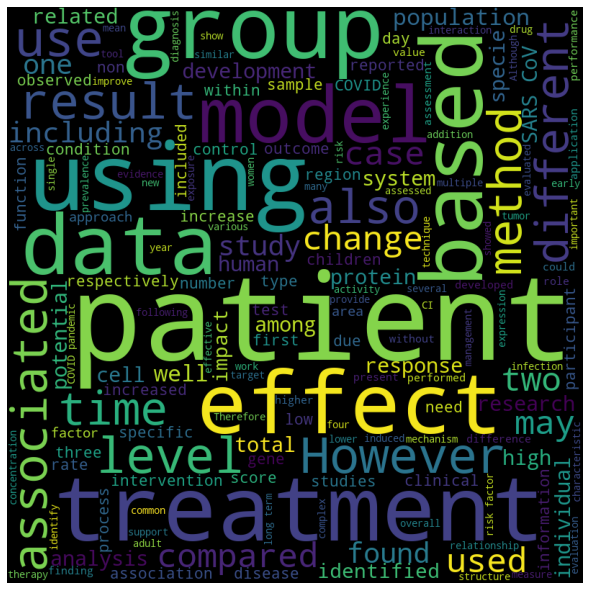

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

based on the wordcloud shown above we can extend our stopwords list to include some other words.

In [ ]:
stopwords.extend(['however', 'use', 'show', 'therefore', 'within', 'also', 'may', 
                  'due', 'find', 'data', 'work', 'works', 'vs', '', 'study', 'one',
                  'two', 'studies', 'summary', 'three', 'result', 'patient', 'patients'
                  'used', 'using', 'review', 'health', 'topic', 'patients'])

<a id="text_pre"></a>
# 4. Text preprocessing
 

In [ ]:
def tokenize(text_string):
  return word_tokenize(text_string)

def remove_punct(text):
    text  = [''.join(filter( lambda x: x in 'abcdefghijklmnopqrstuvwxyz', word.lower()))
             for word in text]
    return text

def remove_stopwords(text):
    text = [word for word in text if word not in stopwords]
    return text


def stemming(text):
    stemm = nltk.PorterStemmer()
    text = [stemm.stem(word) for word in text]
    return text


def lemmatizer(text):
    lemm = nltk.WordNetLemmatizer()
    text = [lemm.lemmatize(word) for word in text]
    return text

def clean_text(text):
  text = tokenize(text)
  text = remove_punct(text)
  # text = stemming(text)
  text = remove_stopwords(text)

  return text

In [ ]:
cleaned_text_data = [ x for x in data['all_text'].progress_apply(clean_text)]

  0%|          | 0/4999 [00:00<?, ?it/s]

# LDA
- At first, We create a Bag of Words (BOW) dictionary from the cleaned and processed docs containing the number of times a word appears in the training set.

In [ ]:
id2word = Dictionary(cleaned_text_data)
corpus = [id2word.doc2bow(text) for text in cleaned_text_data]

In [ ]:
len(corpus)

4999

explore some terms generated from bow

In [ ]:
[(id2word[id], freq) for id, freq in corpus[0]][:20]

[('achieve', 1),
 ('analyzed', 1),
 ('approach', 1),
 ('average', 1),
 ('aware', 1),
 ('calculated', 1),
 ('calculation', 1),
 ('captured', 1),
 ('coding', 2),
 ('commonly', 1),
 ('compared', 1),
 ('consequences', 1),
 ('coordination', 1),
 ('coupling', 1),
 ('couplings', 1),
 ('cv', 7),
 ('determined', 1),
 ('develop', 1),
 ('differences', 1),
 ('differing', 1)]

### Baseline LDA model
- We build the baseline lda model with number of topic = 20

In [ ]:
num_topics = 20
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=num_topics)

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"model" + 0.005*"cell" + 0.005*"analysis" + 0.005*"method" + '
  '0.004*"cells" + 0.004*"results" + 0.003*"time" + 0.003*"genes" + '
  '0.003*"used" + 0.003*"dna"'),
 (1,
  '0.013*"women" + 0.004*"maternal" + 0.004*"treatment" + 0.004*"among" + '
  '0.004*"p" + 0.003*"pregnant" + 0.003*"group" + 0.003*"ci" + 0.003*"cancer" '
  '+ 0.003*"associated"'),
 (2,
  '0.008*"nov" + 0.008*"c" + 0.006*"species" + 0.005*"sp" + 0.004*"group" + '
  '0.004*"cardiac" + 0.003*"new" + 0.003*"genus" + 0.003*"associated" + '
  '0.003*"hfpef"'),
 (3,
  '0.010*"sarscov" + 0.007*"covid" + 0.005*"infection" + 0.005*"respiratory" + '
  '0.004*"virus" + 0.004*"antibodies" + 0.004*"disease" + 0.004*"levels" + '
  '0.003*"treatment" + 0.003*"associated"'),
 (4,
  '0.009*"expression" + 0.006*"p" + 0.004*"cells" + 0.004*"cell" + '
  '0.004*"results" + 0.003*"students" + 0.003*"growth" + 0.003*"used" + '
  '0.003*"exposure" + 0.003*"different"'),
 (5,
  '0.005*"treatment" + 0.004*"group" + 0.003*"bone"

### Get model with optimum number of topics

In [ ]:
def find_optim_num_topic(dictionary , corpus , text , max=29 , start = 5 , step = 2):
    
    max_cohernce = 0
    best_model = 0
    coherence_values = []
    optim_num_topics = 0
    for num_topics in tqdm(range(start , max , step)):
        model =  LdaModel(corpus=corpus,
                          id2word=id2word,
                          num_topics=num_topics,
                          update_every=1)
        

        coherencemodel = CoherenceModel(model=model , 
                                        texts=text , 
                                        dictionary=dictionary , 
                                        coherence='c_v')
        
        coherence_value = coherencemodel.get_coherence()
        if coherence_value > max_cohernce:
          max_cohernce = coherence_value
          best_model = model
          optim_num_topics = num_topics

        coherencemodel = CoherenceModel(model=model , texts=text , dictionary=dictionary , coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(f"With num_topics={num_topics}, The coherence_value={coherence_value}")
    print(f"Return best model with num_topics={optim_num_topics} and max coherence_value={max_cohernce:.2f}")
    return best_model , coherence_values

In [ ]:
best_model, coherence_values = find_optim_num_topic(dictionary=id2word , corpus=corpus , text=cleaned_text_data)

  0%|          | 0/12 [00:00<?, ?it/s]

With num_topics=5, The coherence_value=0.3498697636192429


With num_topics=7, The coherence_value=0.30241852906823913


With num_topics=9, The coherence_value=0.3056427503667376


With num_topics=11, The coherence_value=0.3343722415424483


With num_topics=13, The coherence_value=0.3406946340161988


With num_topics=15, The coherence_value=0.34475761404561084


With num_topics=17, The coherence_value=0.34913265000805893


With num_topics=19, The coherence_value=0.34933477033666893


With num_topics=21, The coherence_value=0.3486400961007189


With num_topics=23, The coherence_value=0.34054348026867737


With num_topics=25, The coherence_value=0.3499642761074512
With num_topics=27, The coherence_value=0.33254524303431554
Return best model with num_topics=25 and max coherence_value=0.35


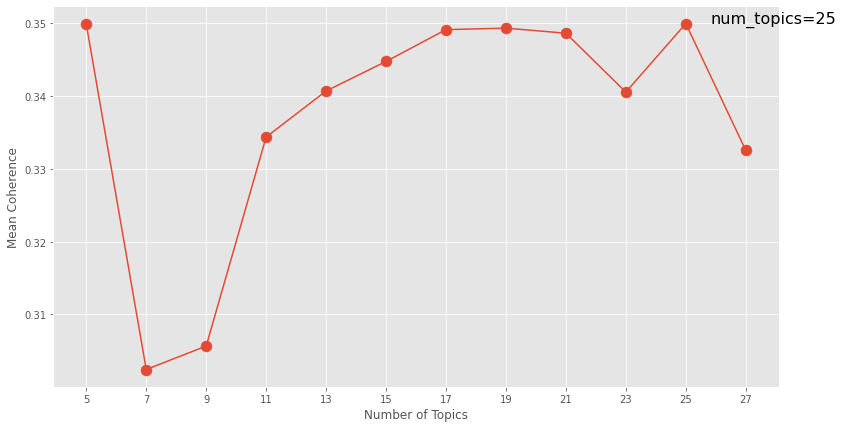

In [ ]:
fig = plt.figure(figsize=(13,7))
# create the line plot
k_values = range(5 , 29 , 2)
ax = plt.plot( k_values, coherence_values )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherence_values, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherence_values)
xpos = coherence_values.index(ymax)
best_k = k_values[xpos]
plt.annotate( "num_topics=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

### Visulize the model

In [ ]:
 LDAvis= gensimvis.prepare(best_model, corpus, id2word)

In [ ]:
LDAvis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.111705 -0.057358       1        1  10.620300
14     0.115045  0.023102       2        1   9.282759
21    -0.043842  0.018495       3        1   5.754602
16    -0.144617 -0.066066       4        1   5.596087
2      0.057760 -0.102983       5        1   5.314861
12    -0.133786 -0.043293       6        1   5.222685
17     0.107710 -0.025591       7        1   5.080759
11     0.040818  0.020599       8        1   4.053051
4      0.090456  0.001775       9        1   3.806746
15     0.033189  0.010326      10        1   3.802105
9      0.098964  0.059221      11        1   3.771973
6     -0.124304  0.013832      12        1   3.728701
8     -0.044548  0.017744      13        1   3.266169
0      0.010625 -0.057133      14        1   3.158663
3     -0.058864  0.062719      15        1   3.084629
19    -0.042750  0.039664      16        1   3.042968
5     -0.024492 -0.062150      17        1   2.951555
24     0.038176  0.040972      18        1   2.629503
7     -0.030668  0.045619      19        1   2.598192
22    -0.062703  0.020331      20        1   2.454018
10    -0.006524  0.086249      21        1   2.384667
13     0.049657  0.048452      22        1   2.383704
23     0.003161 -0.051739      23        1   2.204650
20     0.016728 -0.072104      24        1   2.089706
18    -0.056897  0.029315      25        1   1.716945, topic_info=               Term         Freq        Total Category  logprob  loglift
252            care  1405.000000  1405.000000  Default  30.0000  30.0000
2622        species  1142.000000  1142.000000  Default  29.0000  29.0000
1270          covid  1945.000000  1945.000000  Default  28.0000  28.0000
493           cells  1071.000000  1071.000000  Default  27.0000  27.0000
311               p  1883.000000  1883.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
311               p    20.291526  1883.988416  Topic25  -6.3464  -0.4663
1138      different    19.205954  1170.628654  Topic25  -6.4014  -0.0455
218         results    19.245569  1794.322080  Topic25  -6.3993  -0.4705
492            cell    18.738197   921.005381  Topic25  -6.4260   0.1697
459   significantly    17.903667   915.887409  Topic25  -6.4716   0.1297

[2002 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
26289      4  0.887857     aamylase
25503     14  0.914490          aas
26322      6  0.075915          abc
26322     24  0.835069          abc
14523     13  0.913421  aberrations
...      ...       ...          ...
3991      24  0.023151        youth
7745       9  0.852898      youtube
28679      1  0.069769       zambia
28679     17  0.837222       zambia
15774      1  0.945234       zoster

[11709 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 15, 22, 17, 3, 13, 18, 12, 5, 16, 10, 7, 9, 1, 4, 20, 6, 25, 8, 23, 11, 14, 24, 21, 19])

### Map docoments to topics

In [ ]:
data['lda_topic'] = [best_model.get_document_topics(x)[0][0] for x in tqdm(corpus)]

  0%|          | 0/4999 [00:00<?, ?it/s]

In [ ]:
data.head()

,ArticleID,Title,Abstract,all_text,lda_topic
0,34153941,Stable Coordination Variability in Overground ...,Coordination variability (CV) is commonly anal...,Stable Coordination Variability in Overground ...,9
1,34153942,Weak Hip Strength Increases Dynamic Knee Valgu...,Clinical Scenario: Dynamic knee valgus (DKV) i...,Weak Hip Strength Increases Dynamic Knee Valgu...,2
2,34153964,Current and Future Projections of Amyotrophic ...,Various methodologies have been reported to as...,Current and Future Projections of Amyotrophic ...,1
3,34153968,Disparities between Asian and Non-Asian Thromb...,As outcomes for acute ischemic stroke (AIS) va...,Disparities between Asian and Non-Asian Thromb...,1
4,34153978,Maternal Factors Predicting Loss to Follow-Up ...,Because hearing loss in children can result in...,Maternal Factors Predicting Loss to Follow-Up ...,1


#### Count of dataset Documents in each topic

Text(0.5, 1.0, 'Number of documents per topic in the data')

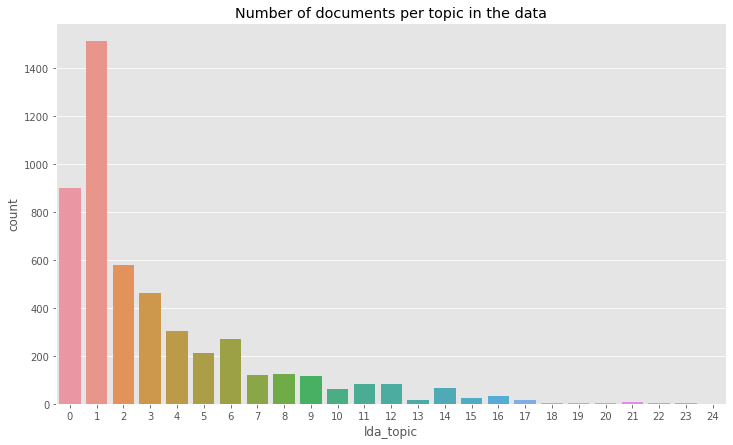

In [ ]:
plt.figure(figsize=(12, 7))
import seaborn as sns
sns.countplot(data['lda_topic'])
plt.title("Number of documents per topic in the data")

#### Example of text from the same lda-topic catogery

In [ ]:
data[data['lda_topic']==5]['all_text'][4979]

"Can Increasing Scale Efficiency Curb Agricultural Nonpoint Source Pollution?The Chinese government has made great efforts to improve the scale efficiency of land through various measures during recent years, hoping to realize the coordinated developing goal of promoting agricultural benefits and protecting the environment. Statistics show that China's land scale efficiency has steadily increased, but agricultural nonpoint source (NPS) pollution has also increased, which seems contrary to the expected outcome. Can increasing scale efficiency really curb agricultural NPS pollution? This study uses provincial-level data from China, together with a panel model and spatial econometric model, to investigate the relationship between scale efficiency and agricultural NPS pollution. It is found that the increase of scale efficiency aggravates the agricultural NPS pollution, and the conclusion still holds after considering spatial effect. The results of spatial analysis shows that the agricultu

In [ ]:
data[data['lda_topic']==5]['all_text'][38]

'PARTICULARITIES ASSOCIATED WITH THE EXPRESSION OF GLIAL ACIDIC FIBRILLARY PROTEIN ON THE STRUCTURAL COMPONENTS OF CEREBELLUM OF THE RATS INFLUENCED BY THE FOOD ADDITIVES COMPLEX.The aim: To define the degree for glial acidic fibrillary protein expression on the structural components of cerebellum of the rats in health and when rats influenced by the food additives complex.,Materials and methods: In order to determine the degree of expression of the immunohistochemical marker GFAP on the structural components of the cerebellum of rats we applied immunohistochemical, morphometric and statistical methods in our study.,Results: In histological specimens at the end of 1st week of observation in the gray matter of the cerebellum there occurred a gradual increase in 1.16 times of the average number of GFAP-positive cells. At the end of 4th week of the experimental study, the average number of GFAP-positive cells increased accurately (at p<0.05 compared to the control group) in 1.27 times, at

It seems that the two text samples are not discussing the same topic. So, We will try to use the BerTopic to see if it could enhance the results.

# Using BerTopic
In this section we will use BerTopic for topic modeling and we will try to use two diffrent pretrained Languge Models(LM) to make the emmebdings. 
> - The first one will be general LM trained on text in diffrent and general topics.
> - The second, is LM that trained on BIO data which could fit the task more.

In [ ]:
docs = [' '.join(doc) for doc in tqdm(cleaned_text_data)]

  0%|          | 0/4999 [00:00<?, ?it/s]

## Roberta-model
In this section, We used the pretraine LM Roberta-base model to generate the embeddings. The model was pretrained on the reunion of five datasets:
> - BookCorpus, a dataset consisting of 11,038 unpublished books;
> -English Wikipedia (excluding lists, tables and headers) ;
> -CC-News, a dataset containing 63 millions English news articles crawled between September 2016 and February 2019.
> -OpenWebText, an opensource recreation of the WebText dataset used to train GPT-2,
> -Stories a dataset containing a subset of CommonCrawl data filtered to match the story-like style of Winograd schemas.

In [ ]:
bert_model = BERTopic(verbose=True)  


In [ ]:
topics, probabilities = bert_model.fit_transform(docs)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

2022-04-14 23:41:57,141 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-04-14 23:42:40,162 - BERTopic - Reduced dimensionality with UMAP
2022-04-14 23:42:40,638 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
bert_model.get_topic_info()

,Topic,Count,Name
0,-1,1779,-1_wa_patient_studi_thi
1,0,265,0_speci_sp_nov_new
2,1,159,1_care_health_student_profession
3,2,138,2_mental_depress_health_psycholog
4,3,136,3_water_habitat_land_area
...,...,...,...
74,73,12,73_ibd_bowel_coliti_crohn
75,74,11,74_cochlear_speechlanguag_tinnitu_speech
76,75,10,75_amino_acid_lysosom_pathway
77,76,10,76_prognost_mutat_prognosi_crc


The model auto-generate 78 topics from the data. The "-1" labeled topic represent the outliers so, we can ignore it. So, We can reduce the number of the topics to 15 ( decreasing the number of topics to 15 based on the 2-d visulization for the 78 topics which showed that the topics can have a more condensed representation.

In [ ]:
bert_model.reduce_topics(docs, topics, nr_topics=15)

In [ ]:
bert_model.get_topic_info()

,Topic,Count,Name
0,-1,3124,-1_wa_patient_studi_thi
1,0,265,0_speci_sp_new_nov
2,1,184,1_care_health_patient_studi
3,2,153,2_mental_depress_health_sleep
4,3,137,3_cardiac_stroke_patient_risk
5,4,136,4_water_area_model_habitat
6,5,134,5_covid_vaccin_health_pandem
7,6,117,6_patient_cancer_tumor_wa
8,7,113,7_children_child_age_dental
9,8,109,8_sarscov_infect_viral_covid


### Visualization

In [ ]:
bert_model.visualize_topics()

In [ ]:
bert_model.visualize_barchart(top_n_topics=10)

## BioBert

In this section, we used the pretrained biobert-base-cased-v1.1 to generate the word embeddings. the model is a pre-trained biomedical language representation model for biomedical text mining tasks. So using it can give us more represntative embeddings for the data. 

In [ ]:

from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('dmis-lab/biobert-base-cased-v1.1')
bio_topic_model = BERTopic(embedding_model=embedding_model, verbose=True, nr_topics=15, calculate_probabilities=True)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/dmis-lab_biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
topics, probabilities = bio_topic_model.fit_transform(docs)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

2022-04-16 00:51:03,275 - BERTopic - Transformed documents to Embeddings
2022-04-16 00:51:18,474 - BERTopic - Reduced dimensionality with UMAP
2022-04-16 00:51:19,728 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-04-16 00:51:23,290 - BERTopic - Reduced number of topics from 58 to 16


In [ ]:
bio_topic_model.get_topic_info()

,Topic,Count,Name
0,-1,3246,-1_covid_analysis_treatment_used
1,0,264,0_species_sp_new_nov
2,1,191,1_species_water_soil_environmental
3,2,174,2_case_rare_report_yearold
4,3,144,3_expression_cell_cells_cancer
5,4,129,4_care_social_research_services
6,5,125,5_care_systematic_implementation_research
7,6,108,6_cells_edcs_amino_cell
8,7,87,7_dna_gene_apa_binding
9,8,86,8_stroke_ventricular_valve_coronary


### Visualization

In [ ]:
bio_topic_model.visualize_topics()

In [ ]:
bio_topic_model.visualize_barchart(top_n_topics=15, n_words=10)

As seen from the barchart visulization sample from the words and its score in the topic and we can see that the words in each topic are similar and somehow representative. So, we can give label to each topic as example:
> - topic  --> label
> - topic-0 --> organisim research
> - topic-1 --> enviromental research 
> - topic-2 --> clinical research
> - topic-3 --> cancer research
> - topic-5 --> Introduction-words
> - topic-7 --> genatic research
> - topic-9 --> chemical experiments 
> - topic-10 --> dental research 
> - topic-11 topic-13 --> neuroscience research 
> - topic-14, topic 12 and topic-4 --> covid-pandemic


In [ ]:
bio_topic_model.visualize_hierarchy()

In [ ]:
bio_topic_model.visualize_heatmap()

### Map each document to topic

In [ ]:
import numpy as np
data['Bertopic_topic'] = topics

Here, we will try to predict the topic that has larger probabilty value instead of topic that has label -1 which represent the outlier.

In [ ]:
outlier_topics = data[data['Bertopic_topic']==-1]

In [ ]:
outlier_topics['out_bert_topic']=[np.argmax(bio_topic_model.transform(' '.join(clean_text(x)))[1], axis=1)[0] 
                                                             for x in tqdm(outlier_topics['all_text'])]

### Test the model with unseen data
We will test the model on unseen data that related to dental research [source](https://journals.sagepub.com/doi/full/10.1177/0022034511425675?casa_token=gIClQOXemEsAAAAA%3AJ8KHEpGYPcPFIZuSNVNu3XZyJ4TTmwKMJTuzzAIdGR7Wo55yr0PPGDD-0idF9G0vbohZYis_Wln9). 

In [ ]:
test_data = "Growing evidence has suggested the utility of short dental implants for oral reconstructive procedures in clinical \
situations of limited vertical bone height. The aim of this review was to systematically evaluate clinical studies of implants\
 < 10 mm in length, to determine short implant-supported prosthesis success in the atrophic jaw. Implant survival, incidence of \
biological and biomechanical complications, and radiographic peri-implant marginal bone loss were evaluated. Screening of eligible \
studies, quality assessment, and data extraction were conducted by two reviewers independently. Meta-analyses were performed by the\
pooling of survival data by implant surface, surgical technique, implant location, type of edentulism, and prosthetic restoration. \
Two randomized controlled trials and 14 observational studies were selected and analyzed for data extraction. In total, 6193 short-implants\
were investigated from 3848 participants. The observational period was 3.2 ± 1.7 yrs (mean ± SD). The cumulative survival rate (CSR) was 99.1%\
(95%CI: 98.8-99.4). The biological success rate was 98.8% (95%CI: 97.8-99.8), and the biomechanical success rate was 99.9% (95%CI: 99.4-100.0). \
A higher CSR was reported for rough-surfaced implants. The provision of short implant–supported prostheses in patients with atrophic alveolar \
ridges appears to be a successful treatment option in the short term; however, more scientific evidence is needed for the long term.."

In [ ]:
clean_test = ' '.join(clean_text(test_data))

In [ ]:
topic, probablites = bio_topic_model.transform(clean_test)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-04-16 01:08:01,989 - BERTopic - Reduced dimensionality with UMAP
2022-04-16 01:08:01,992 - BERTopic - Predicted clusters with HDBSCAN
2022-04-16 01:08:02,014 - BERTopic - Calculated probabilities with HDBSCAN


In [ ]:
print (f"The most probably related to topic to the text is topic-{topic[0]}")

The most probably related to topic to the text is topic-10


The result show that the test-text is most probably related to topic-10 ( dental research topic)

# Conclousion
- Two methods were used for topic extraction:
>1. **LDA** <br>
>> - The LDA is assuming that each document is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.
>> - The LDA model predict the topic distrpution for document based in words without taking the context in consideration that is why it is somehow predicting the same topics for unrealted documents.<br>

>>2. **BerTopic**<br>
>>> - BERTopic is a topic modeling technique that taking advantage from transformers and c-TF-IDF to generate more representative topic clusters.
>>> - I tried to use two differnt models to extract the emmbedings from the data . 
>>> - The first model was a general-purpose pre-trained model which produce not bad results.
>>> - The second model was a Bio-purpose pre-trained model which trained on bio data such journal-papers and clincal data. 
>>> - The result from the Bio-Bert model was the best results which generate coherent topic clusters.
>>> - There is no specific method to evalaute the BerTopic model. It just depends on the human evalaution *(according to the package auther)*. So, Based on that, It has the best result.  
